In [2]:
import numpy as np
import loompy
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp
import matplotlib.pyplot as plt
import glob
import bbknn
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
from pandas.core.index import RangeIndex

import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.1 (python 3.7.6) on 2020-08-04 11:14.
 Your version: 		 0.2.1 
 Latest version: 	 0.2.2


In [3]:
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.5.0 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.1


In [2]:
sc.settings.set_figure_params(dpi=140)

In [3]:
adata1 = sc.read_loom(
    'G:\Lef1RegenPaper\control1.loom',
    sparse=True, cleanup=False, X_name='spliced',
obs_names='CellID',
var_names='Gene', dtype='float32')   

adata2 = sc.read_loom(
   'G:\Lef1RegenPaper\sm22.loom',
    sparse=True, cleanup=False, X_name='spliced',
obs_names='CellID',
var_names='Gene', dtype='float32')   


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
adata1.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

adata2.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

In [5]:
adata = adata1.concatenate(adata2, batch_key='Time', batch_categories=['Control','Smo'])

In [6]:
adata

AnnData object with n_obs × n_vars = 5973 × 31053
    obs: 'Clusters', '_X', '_Y', 'Time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

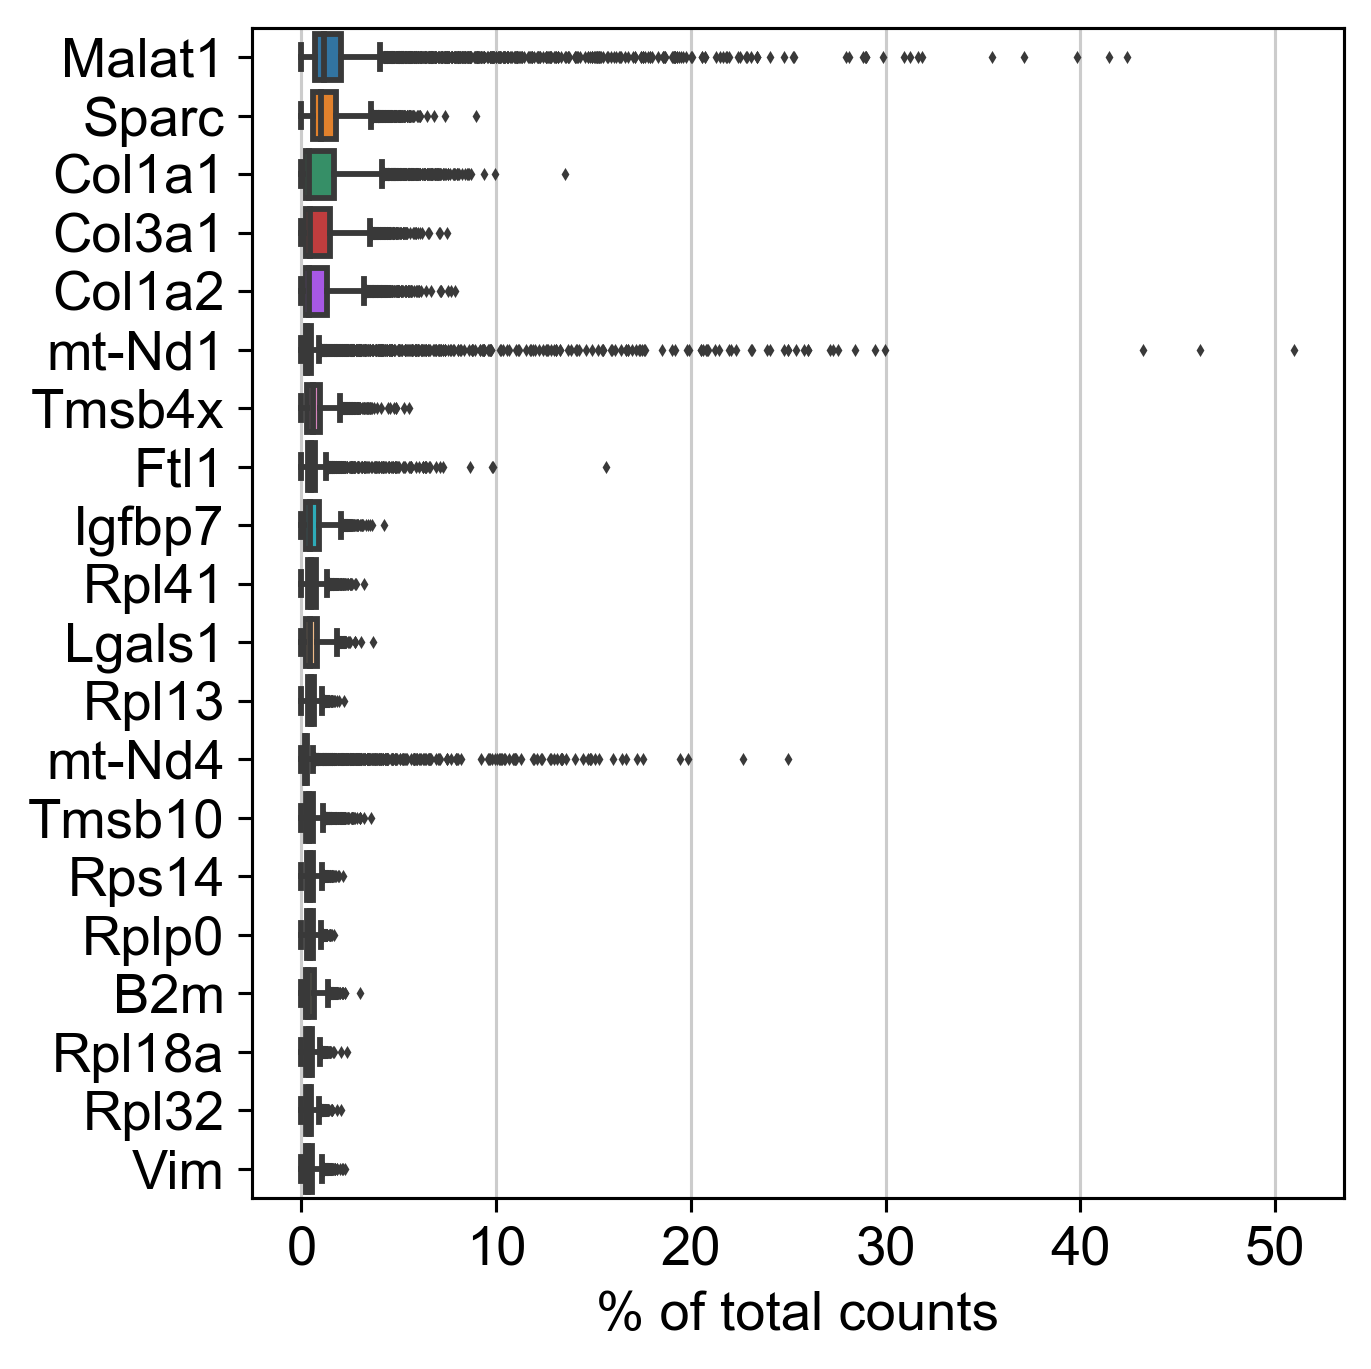

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [9]:
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


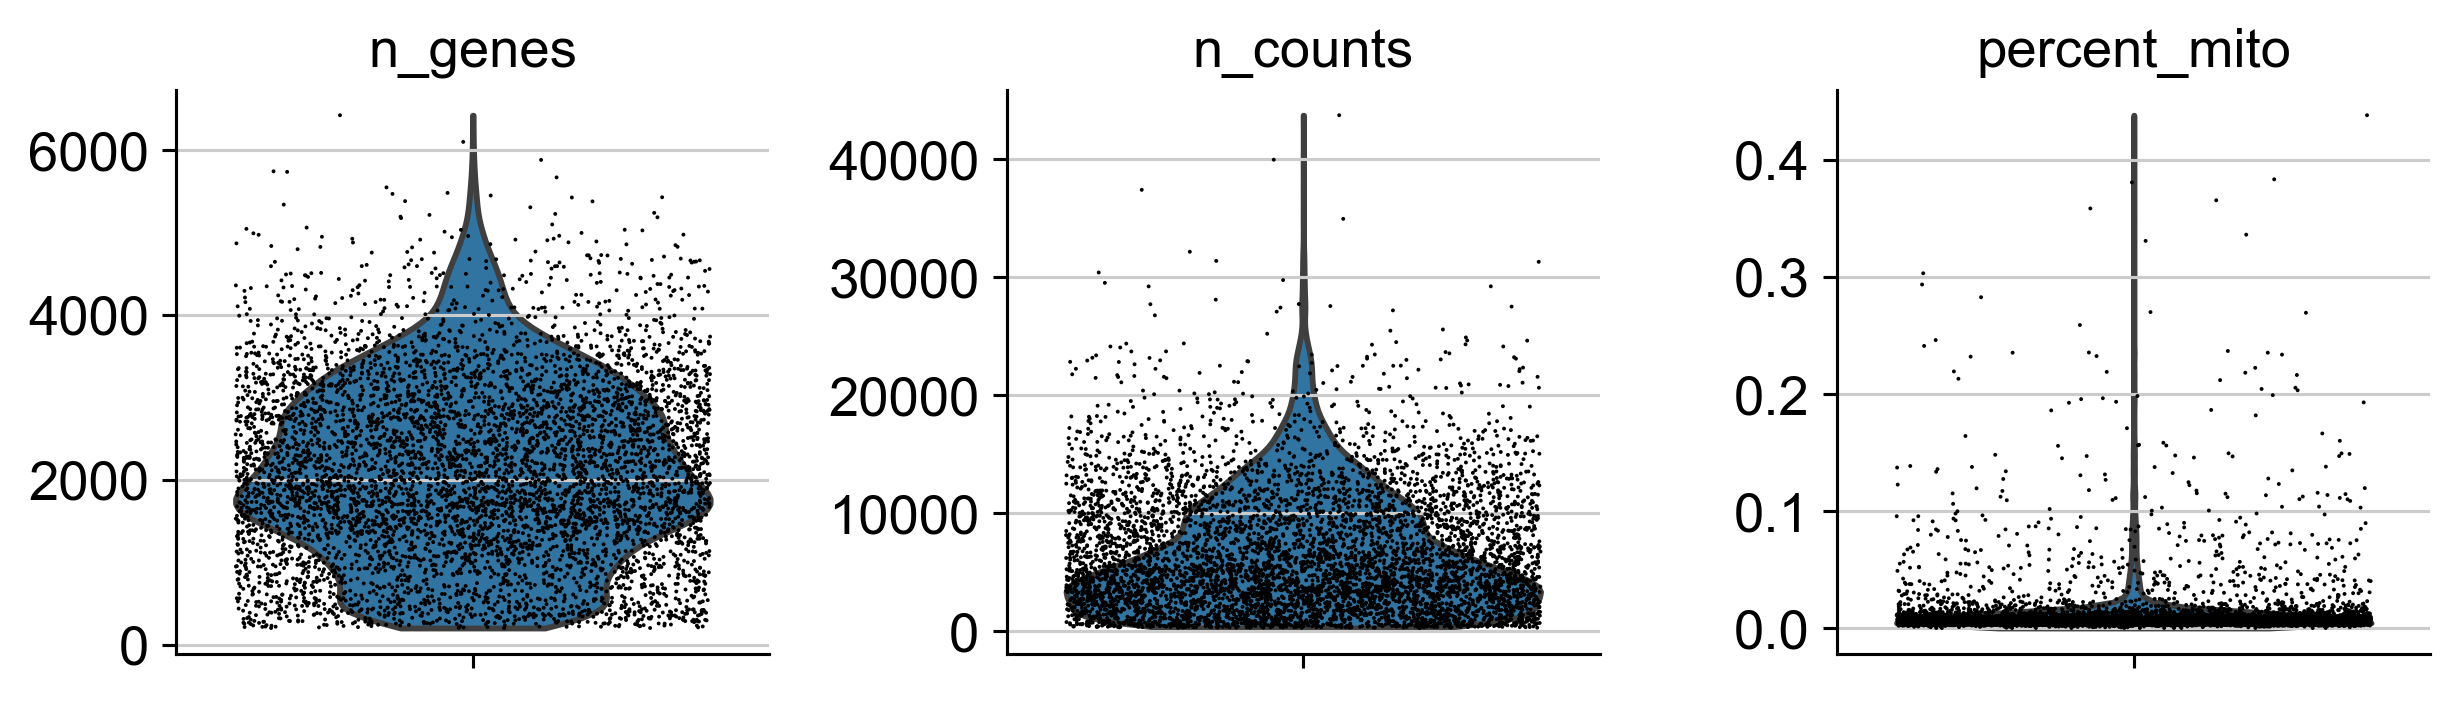

In [10]:
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'],
             jitter=0.4, multi_panel=True)

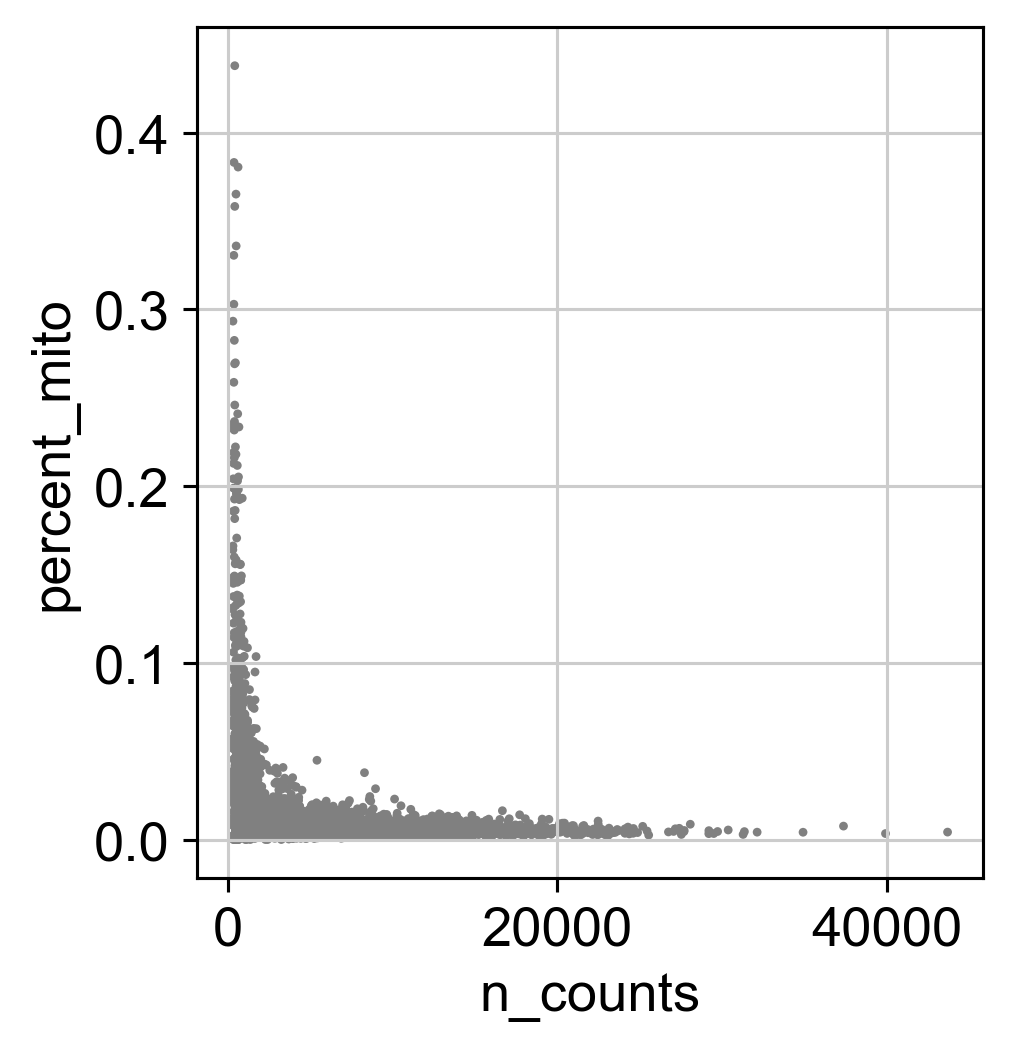

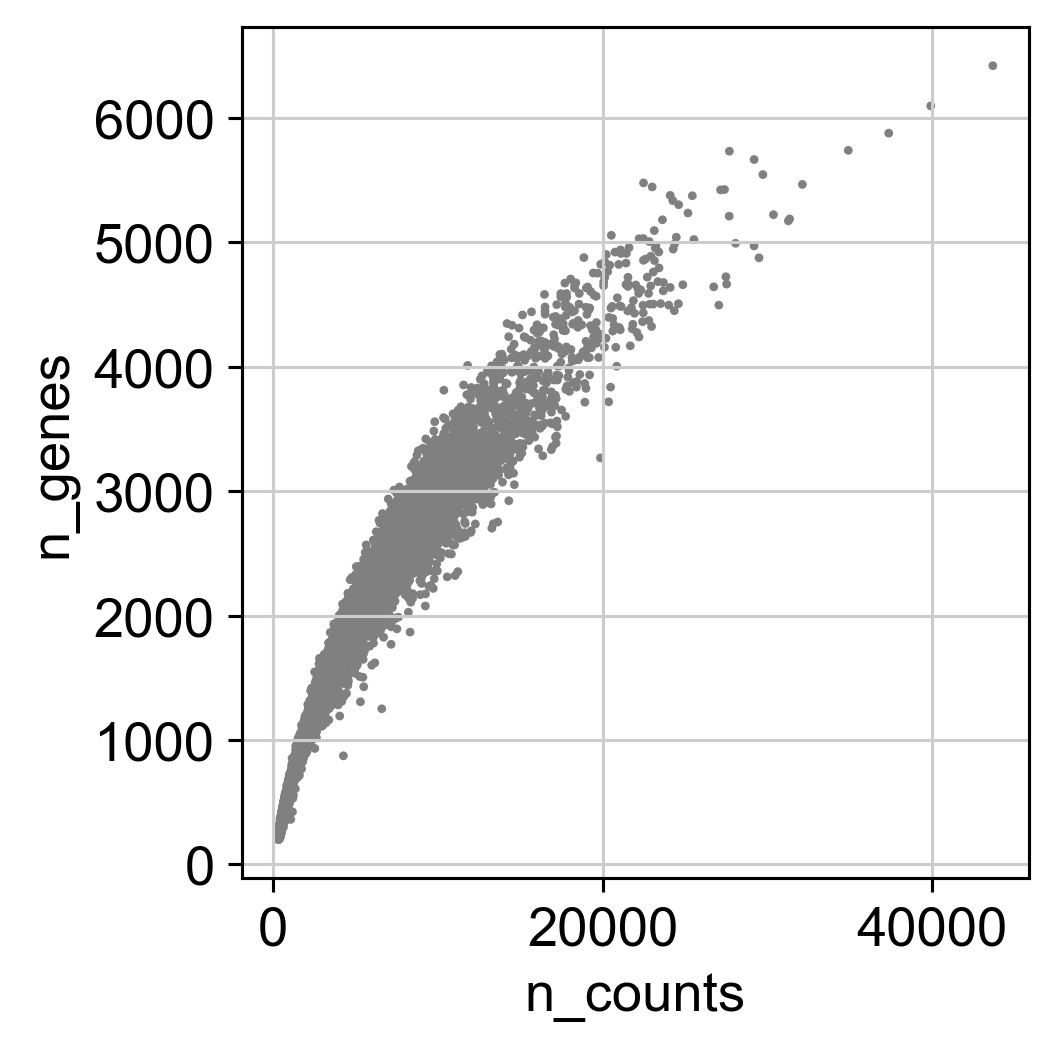

In [11]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [12]:
adata = adata[adata.obs.n_genes < 6000, :]
adata = adata[adata.obs.percent_mito < 0.05, :]

In [13]:
adata

View of AnnData object with n_obs × n_vars = 5617 × 17535
    obs: 'Clusters', '_X', '_Y', 'Time', 'n_genes', 'percent_mito', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [14]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Trying to set attribute `.obs` of view, copying.


In [15]:
sc.pp.log1p(adata)

In [16]:
adata.raw = adata

In [17]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

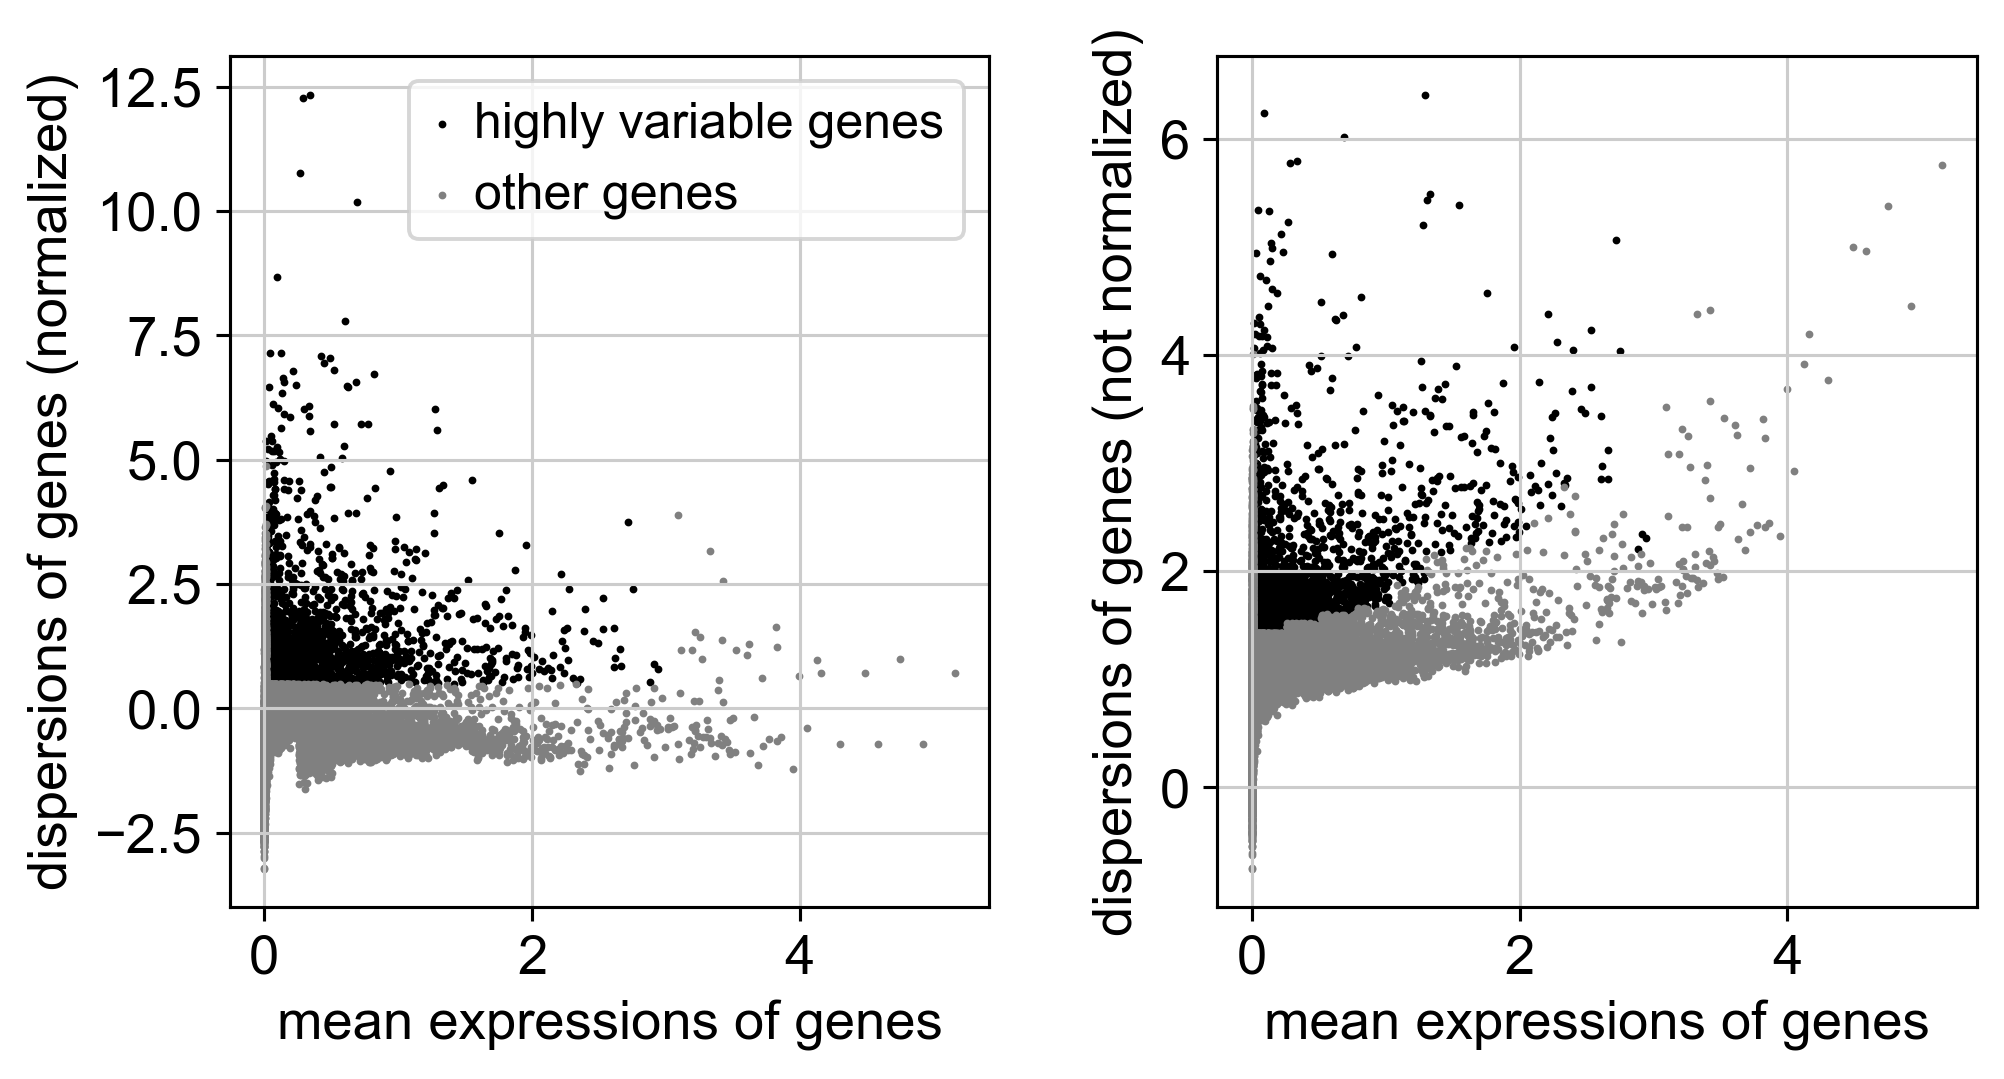

In [18]:
sc.pl.highly_variable_genes(adata)

In [19]:
adata = adata[:, adata.var['highly_variable']]

In [20]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

In [21]:
sc.pp.scale(adata, max_value=10)

In [22]:
sc.tl.pca(adata, svd_solver='arpack')

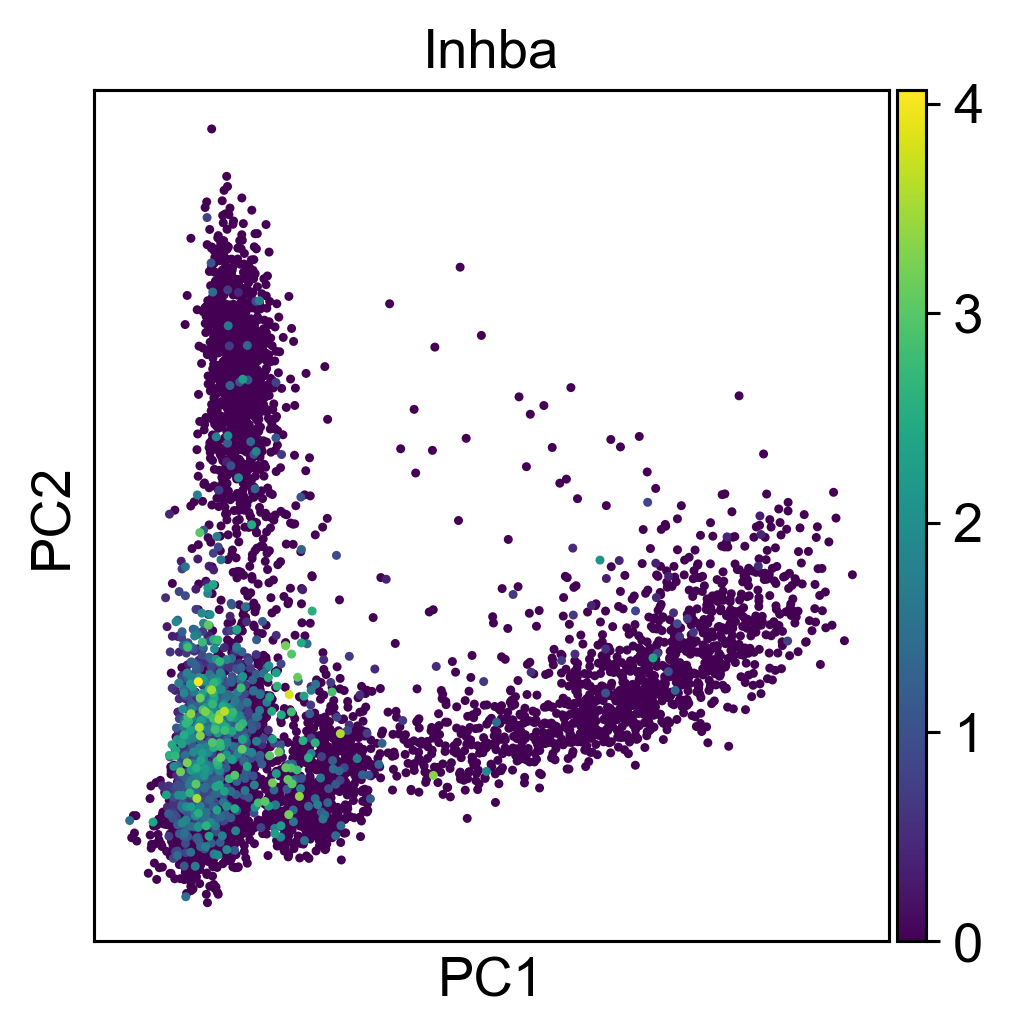

In [23]:
sc.pl.pca(adata, color='Inhba')

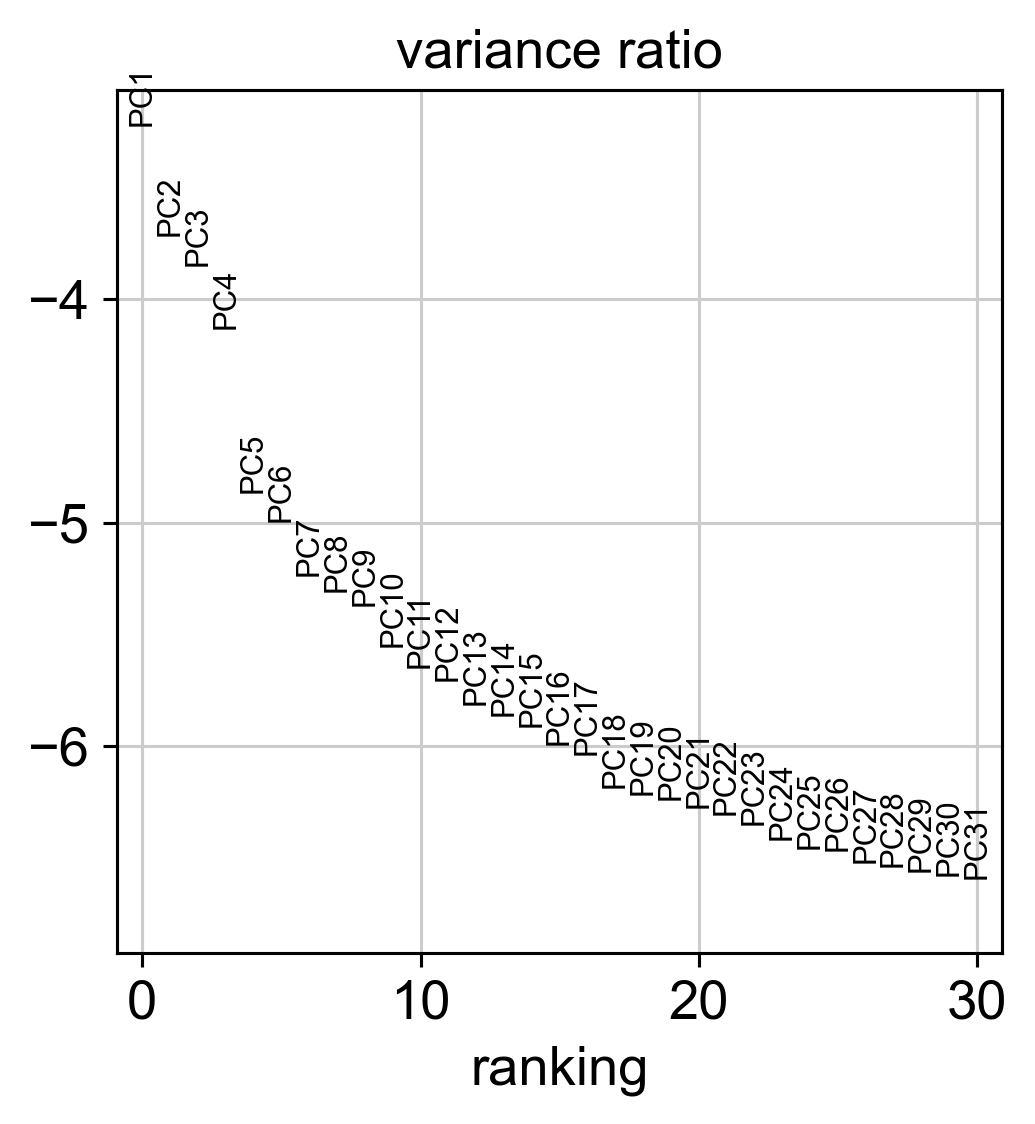

In [24]:
sc.pl.pca_variance_ratio(adata, log=True)

In [25]:
adata

AnnData object with n_obs × n_vars = 5617 × 3430
    obs: 'Clusters', '_X', '_Y', 'Time', 'n_genes', 'percent_mito', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [26]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

In [27]:
sc.tl.umap(adata)

In [28]:
marker_genes = ['Krt14', 'Krt15','Krt17','Krt79','Tyrobp','Lyz2','Ptprc','Dct',
                'Vim','Pdgfra','Twist2','En1','Inhba','Plp1','Mbp','Rgs5','Acta2','Pecam1',
                'Ptch1','Ptch2','Gli1','Gli2','Smo','Tagln','mt-Co3'
                 ]

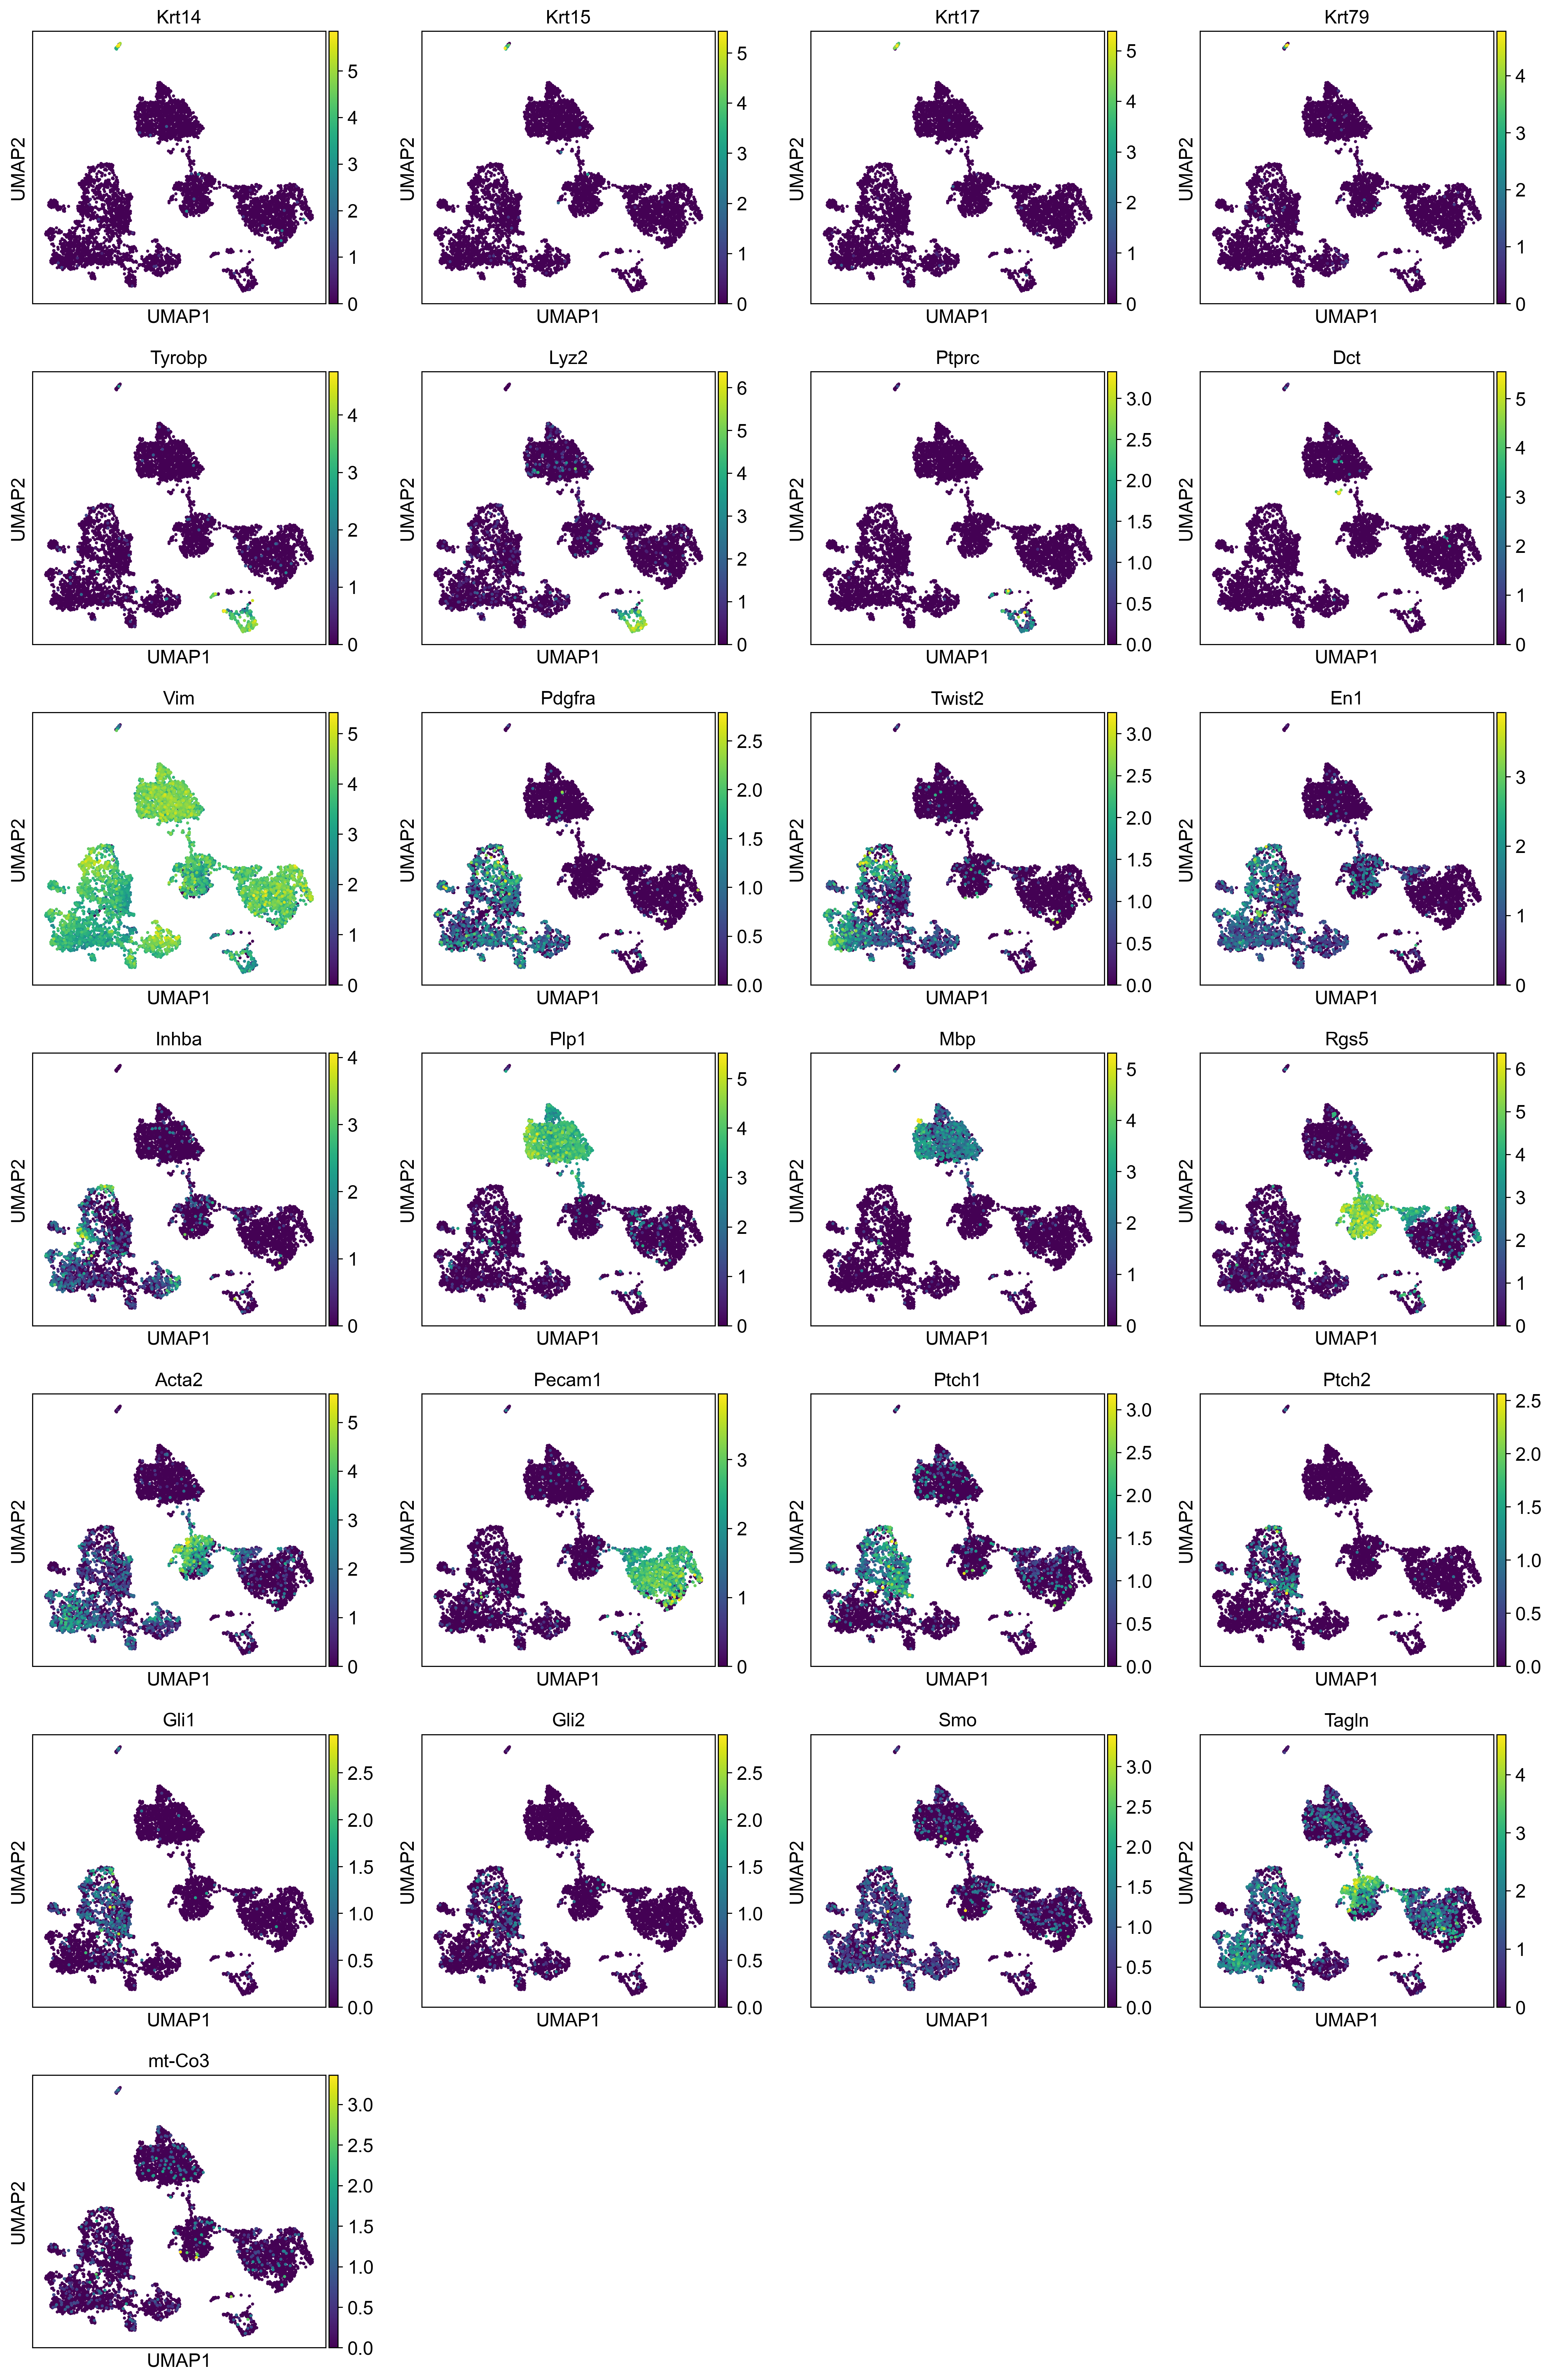

In [29]:
sc.pl.umap(adata, color=marker_genes, color_map='viridis', vmin=0)

In [30]:
sc.tl.leiden(adata, resolution=0.1)

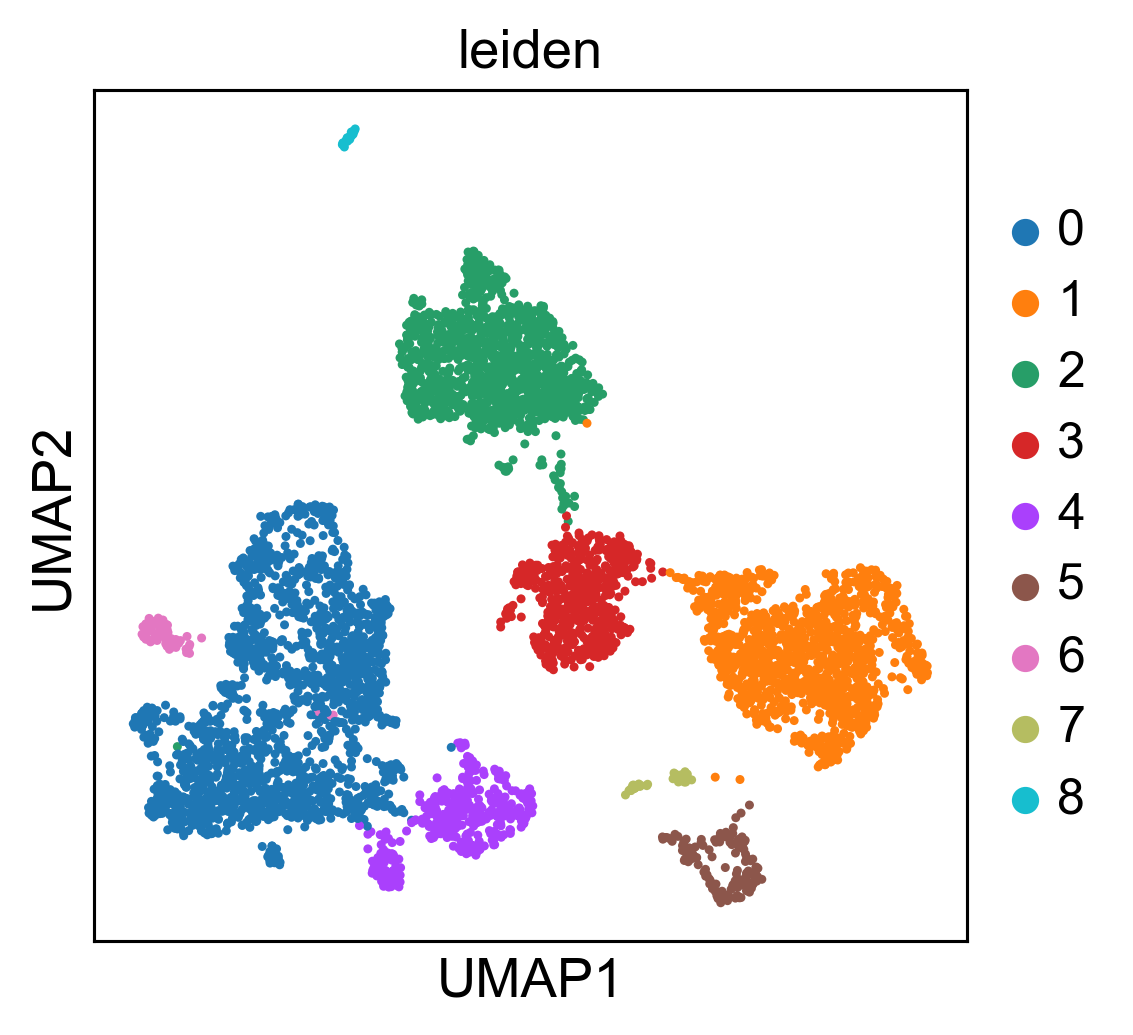

In [31]:
sc.pl.umap(adata, color=['leiden'], legend_loc='right margin', wspace=0.35)

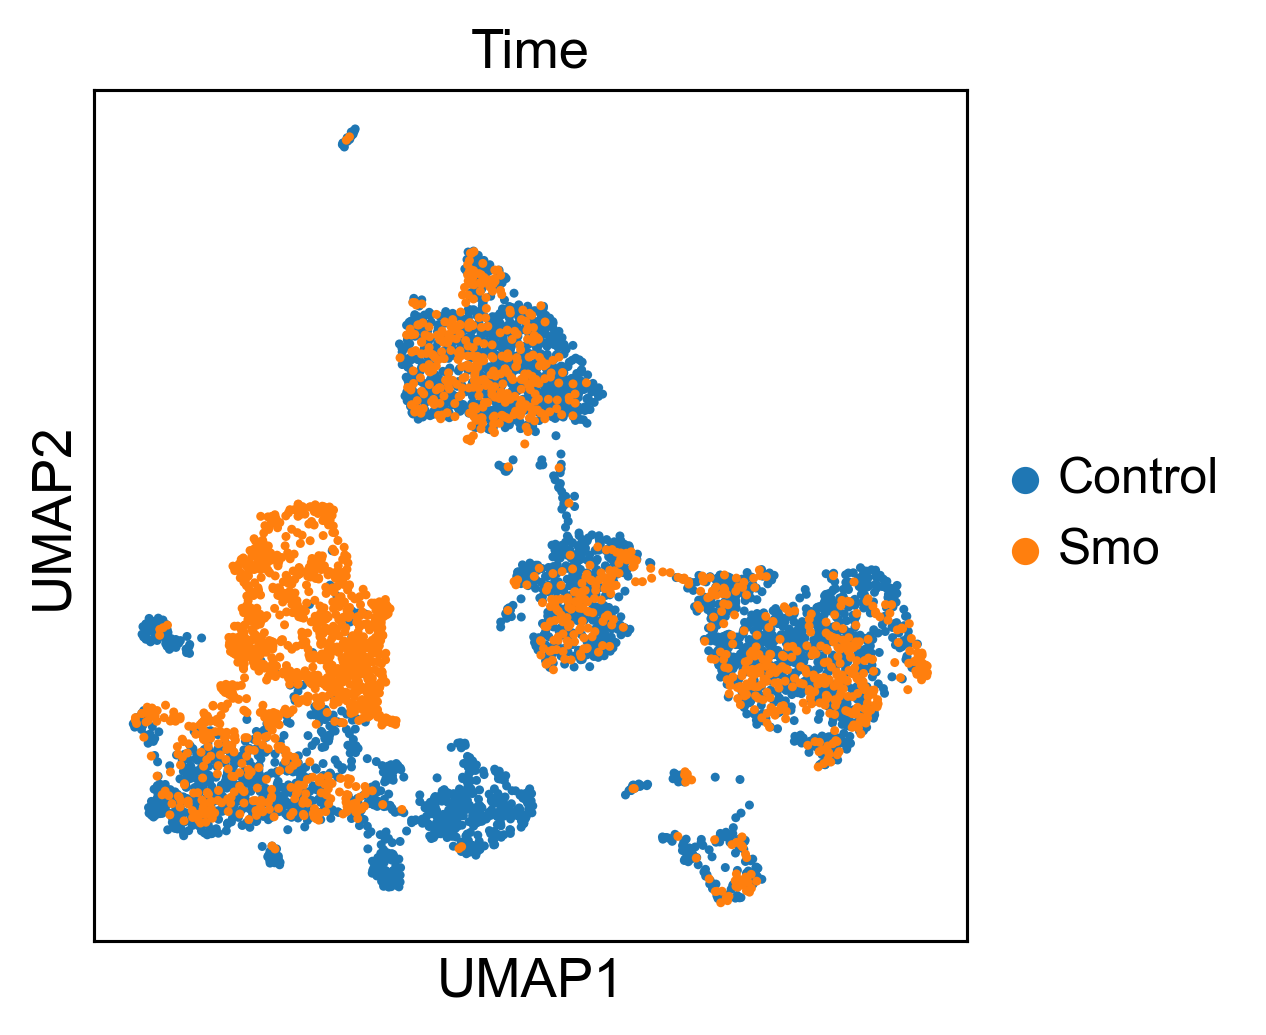

In [32]:
sc.pl.umap(adata, color=['Time'], legend_loc='right margin', wspace=0.35)

In [33]:
adata.obs.groupby(["leiden","Time"]).apply(len)

leiden  Time   
0       Control     715
        Smo        1175
1       Control     906
        Smo         359
2       Control     904
        Smo         353
3       Control     409
        Smo         152
4       Control     373
        Smo           2
5       Control     104
        Smo          34
6       Control      65
        Smo           4
7       Control      32
        Smo           7
8       Control      21
        Smo           2
dtype: int64

In [34]:
new_cluster_names = [
    '0 Contr&Smo22 Fibro',
'1 Blood Vessels', 
'2 Schwan Cells',
'3 Pericytes',
'4 Contr Fibro 1',
'5 Blood/Lympho',
'6 Contr Fibro 2',
'7 Blood',
'8 Keratinocytes'
]
adata.rename_categories('leiden', new_cluster_names)


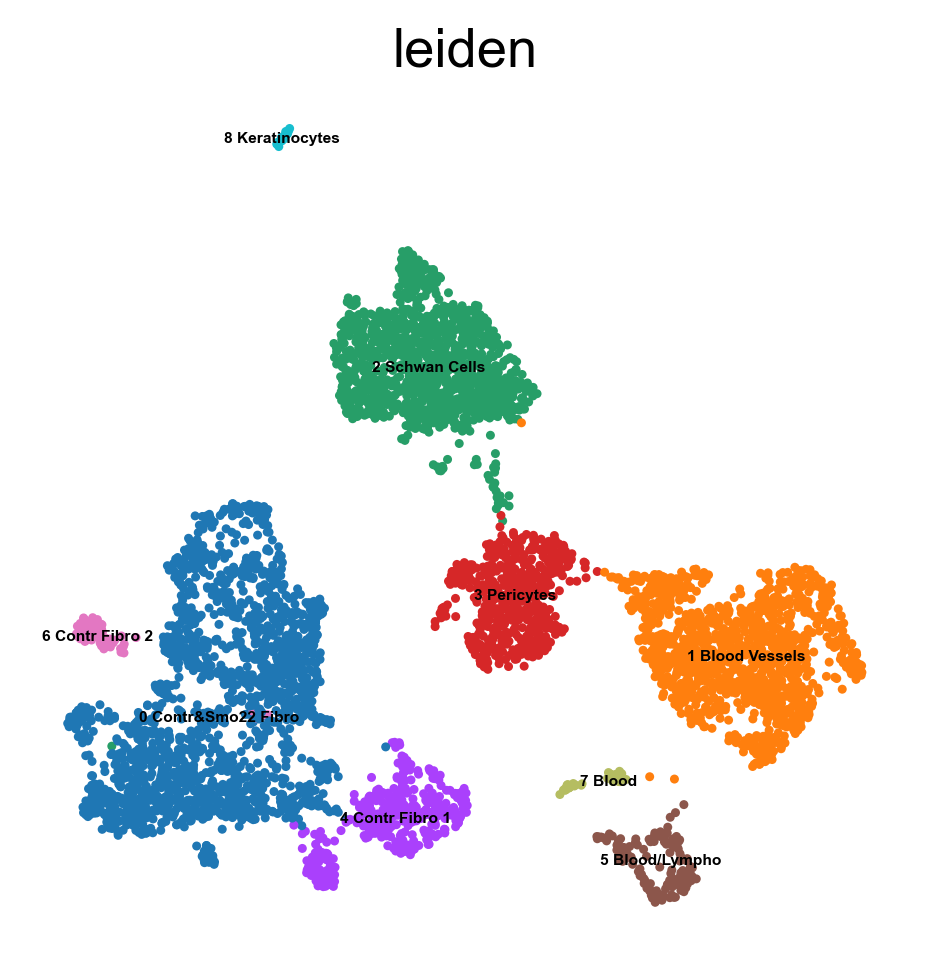

In [35]:

sc.pl.umap(adata, color='leiden', legend_loc='on data', legend_fontsize='4.0',
           frameon=False)

In [36]:

###COLORING THE PLOT####

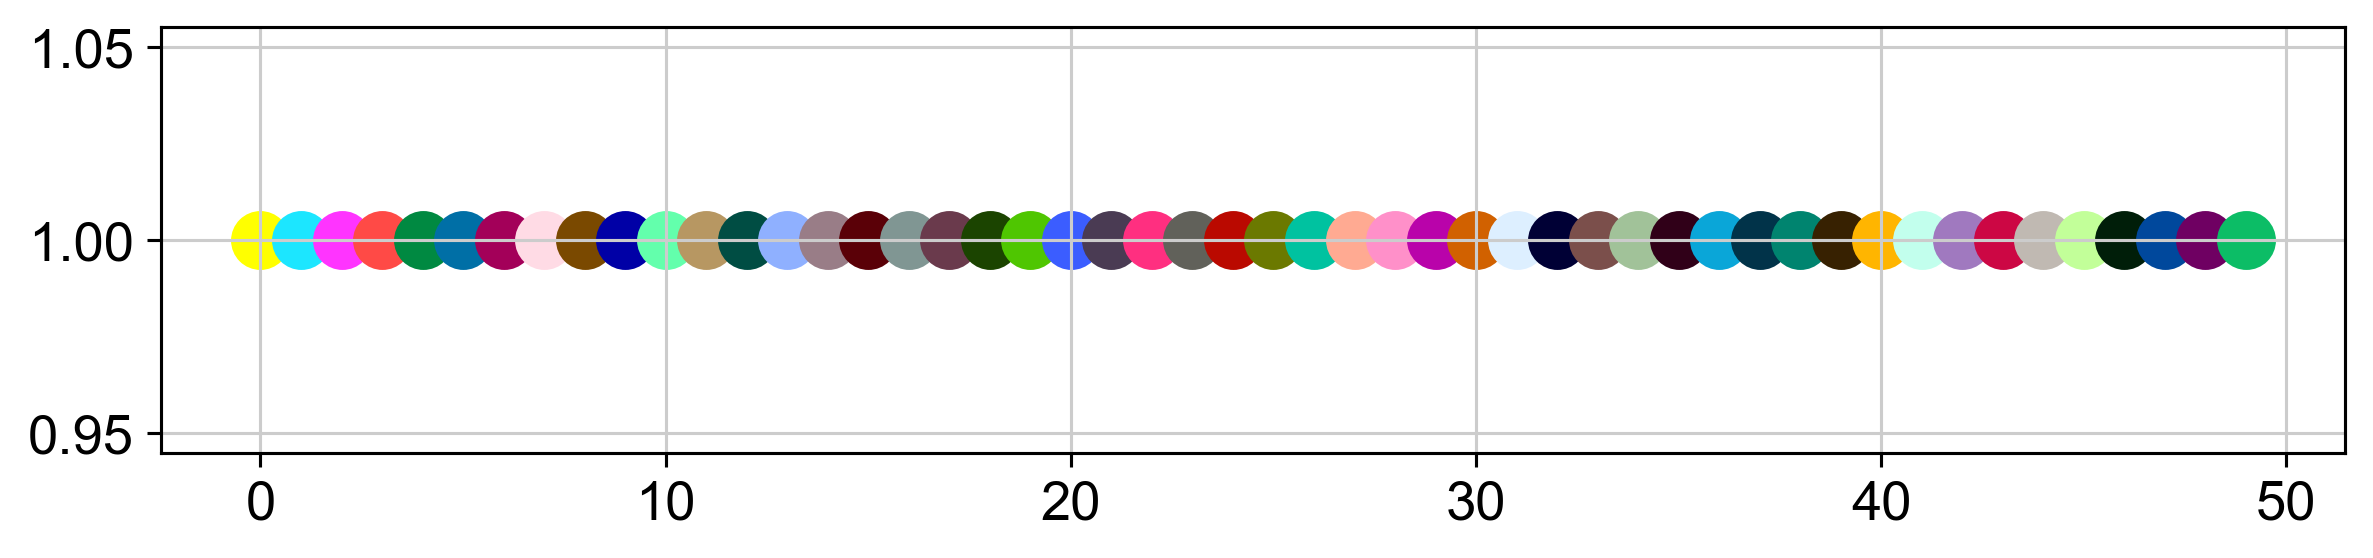

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
pl.figure(figsize=(10, 2))
for i in range(50):
    pl.scatter(i, 1, c=sc.pl.palettes.godsnot_102[i], s=200)
pl.show()

In [38]:
default_colors = np.array(sc.pl.palettes.godsnot_102)
new_colors = np.array(adata.uns['leiden_colors'])

In [39]:
new_colors[[0]] = default_colors[[5]]  # '0 Contr&Smo22 Fibro'
new_colors[[1]] = default_colors[[2]]  #  '1 Blood Vessels'
new_colors[[2]] = default_colors[[8]]  # '2 Schwan Cells'
new_colors[[3]] = default_colors[[19]]  # '3 Pericytes'
new_colors[[4]] = default_colors[[47]]  # '4 Contr Fibro 1'
new_colors[[5]] = default_colors[[40]]  # '5 Blood/Lympho'
new_colors[[6]] = default_colors[[12]]  # '6 Contr Fibro 2
new_colors[[7]] = default_colors[[40]]  # '7 Blood'
new_colors[[8]] = default_colors[[24]]  #  '8 Keratinocytes'

In [40]:

adata.uns['leiden_colors'] = new_colors

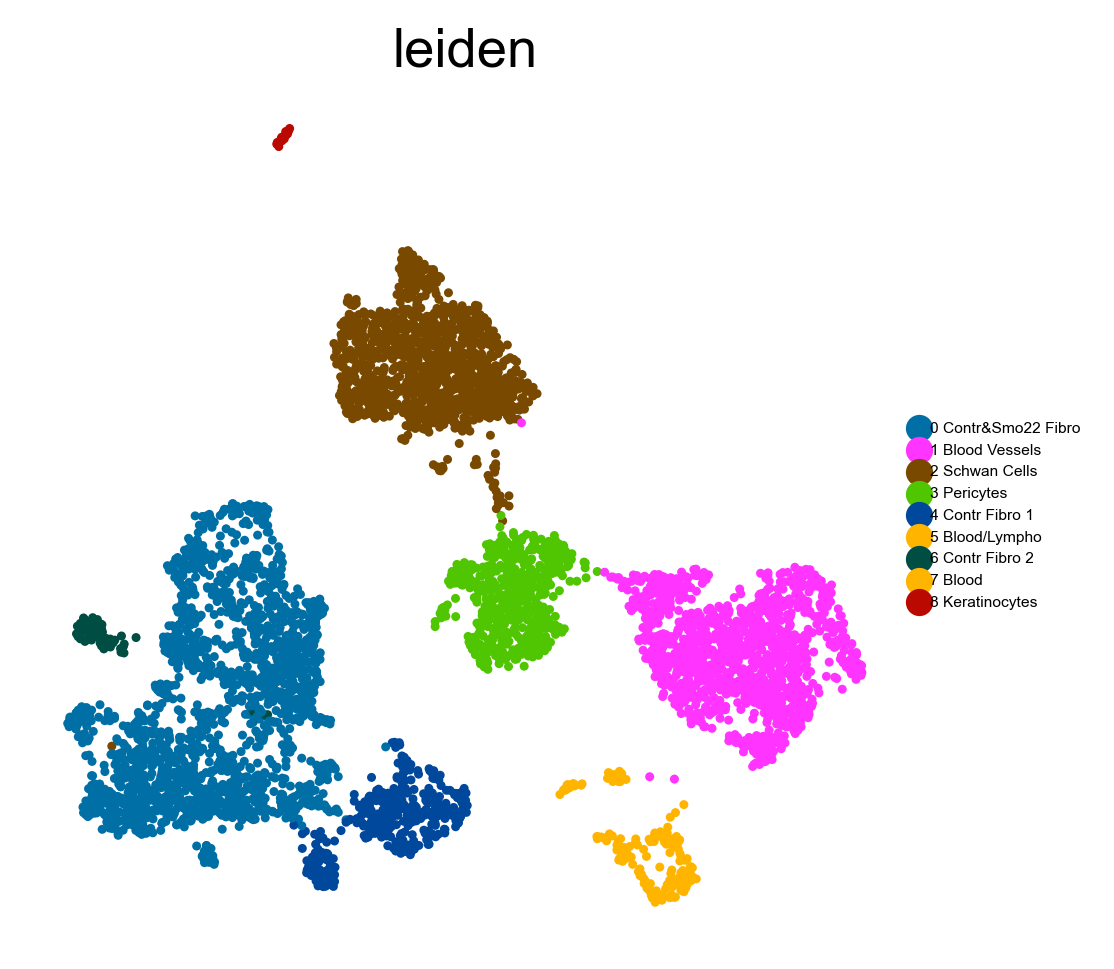

In [41]:
sc.pl.umap(adata, color='leiden', legend_loc='right margin', legend_fontsize='4.0',
           frameon=False)

In [42]:
adata.obs.groupby(["leiden","Time"]).apply(len)

leiden               Time   
0 Contr&Smo22 Fibro  Control     715
                     Smo        1175
1 Blood Vessels      Control     906
                     Smo         359
2 Schwan Cells       Control     904
                     Smo         353
3 Pericytes          Control     409
                     Smo         152
4 Contr Fibro 1      Control     373
                     Smo           2
5 Blood/Lympho       Control     104
                     Smo          34
6 Contr Fibro 2      Control      65
                     Smo           4
7 Blood              Control      32
                     Smo           7
8 Keratinocytes      Control      21
                     Smo           2
dtype: int64